1) There will be 5 images that we will choose that exhibit different scales, orientation, locations, and lighting. (Question: Do These 5 images need to look similar to the one shown in the preprocessing segment of the project file pdf?)

2) For each image, use MSER/Sliding window to detect ROIs
3) Do digit classification on ROI using the CNN models (custom and VGG) trained from the sample dataset 
4) Generate digit sequence in correct order

detection --> recognition --> final output

In [2]:
import os
import time
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import scipy
from sklearn.model_selection import KFold

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset

import torchvision
from torchvision import models
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms

from scipy.signal import convolve2d as conv2
from skimage import restoration

from intermediate_code.CNN import CNN
from intermediate_code.data_preprocessing import raw_data_to_tensor_dataset
from intermediate_code.using_the_models import apply_model_to_data

**APPLYING MY MODEL**

**SAMPLE FULL NUMBERS**

In [2]:
def img_with_contours(img, regions=None):
    if len(img.shape)==2:
        new_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        new_img = img.copy()
    if regions:
        for region in regions:
            x, y, w, h = cv2.boundingRect(region)
            cv2.rectangle(new_img, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)

    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    plt.imshow(new_img)
    plt.axis('off')
    plt.title('MSER Detected Regions')
    plt.show()
    return

In [3]:
CURR_INPUT_DIR = 'test_images/'
test0 = cv2.imread(CURR_INPUT_DIR + 'test-image-1.jpg')
test1 = cv2.imread(CURR_INPUT_DIR + 'test-image-2.jpg')
test2 = cv2.imread(CURR_INPUT_DIR + 'test-image-3.jpg')
test3 = cv2.imread(CURR_INPUT_DIR + 'test-image-4.jpg')
test4 = cv2.imread(CURR_INPUT_DIR + 'test-image-5.jpg')

In [25]:
def test_pipeline(img):
    curr_img = img.copy()

    # ----- BEGINNING THE PIPELINE -----
    height, width = 350, 600
    new_shape = (width, height)                                                      # Resizing
    curr_img = cv2.resize(curr_img, new_shape)
    curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)                       # Greyscaling

    curr_img = cv2.GaussianBlur(curr_img, (9,9), 0)
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
    curr_img = clahe.apply(curr_img)

    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])

    curr_img = cv2.filter2D(curr_img, -1, kernel)
    curr_img = cv2.GaussianBlur(curr_img, (5,5), 0)
   

    # _, curr_img = cv2.threshold(curr_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # kernel = np.ones((3, 3), np.uint8)  # Erosion kernel
    # curr_img = cv2.erode(curr_img, kernel, iterations=1)
    # curr_img = cv2.dilate(curr_img, kernel, iterations=1)

    # Morphological operations to clean up noise
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # curr_img = cv2.morphologyEx(curr_img, cv2.MORPH_OPEN, kernel, iterations=2)
    # curr_img = cv2.morphologyEx(curr_img, cv2.MORPH_CLOSE, kernel, iterations=2)

    # curr_img = cv2.normalize(curr_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    mser = cv2.MSER_create(delta=5, 
                            min_area=1500, 
                            # max_area=10000
    )
    regions, _ = mser.detectRegions(curr_img)

    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
    bboxes = [cv2.boundingRect(h) for h in hulls]
    confidences = [1.0] * len(bboxes) # Placeholder confidences

    # Applying Non-Maximum Suppression
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
    all_bboxes = [cv2.boundingRect(h) for h in hulls]
    valid_regions = []
    valid_bboxes = []
    edge_threshold = 10

    for i, (x, y, w, h) in enumerate(all_bboxes):
        if x > edge_threshold and y > edge_threshold and (x + w) < (width - edge_threshold) and (y + h) < (height - edge_threshold):
            valid_regions.append(regions[i])
            valid_bboxes.append((x, y, w, h))

    confidences = [1.0] * len(valid_bboxes)
    if valid_bboxes:
        bboxes_nms = np.array(valid_bboxes)
        confidences_nms = np.array(confidences)
        keep_indices = cv2.dnn.NMSBoxes(bboxes_nms.tolist(), confidences_nms.tolist(), score_threshold=0.3, nms_threshold=0.5)
        final_regions = [valid_regions[i] for i in keep_indices]
    else:
        final_regions = []

    img_with_contours(curr_img, final_regions)


# test_pipeline(test0)
# test_pipeline(test1)
# test_pipeline(test2)
# test_pipeline(test3)
# test_pipeline(test4)

In [ ]:
model_path = 'current-models/original/cross-entropy-64-0.1.pth'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from PIL import Image
import os
import random

# Assuming you have a CNN class defined (like the one you provided earlier)
# class CNN(nn.Module):
#     ...

def create_no_digit_dataset(image_folder, num_samples, crop_size=32):
    """
    Creates a dataset of "no digit" images by cropping from a folder
    of images, avoiding the center.

    Args:
        image_folder (str): Path to the folder containing images.
        num_samples (int): Number of "no digit" samples to create.
        crop_size (int): Size of the square crop (e.g., 32 for 32x32).

    Returns:
        TensorDataset: A dataset containing the "no digit" images and labels.
    """
    images = []
    labels = []
    all_image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for _ in range(num_samples):
        # Choose a random image
        img_path = random.choice(all_image_paths)
        img = Image.open(img_path).convert('RGB')
        width, height = img.size

        # Ensure the crop size is valid
        if width < crop_size or height < crop_size:
            continue  # Skip images too small to crop

        # Define center region
        center_x = width // 2
        center_y = height // 2
        center_width = width // 4  # Adjust size as needed
        center_height = height // 4

        # Try to find a crop outside the center
        for _ in range(10):  # Try a few times to find a suitable crop
            x = random.randint(0, width - crop_size)
            y = random.randint(0, height - crop_size)
            # Check if the crop overlaps the center
            if not (center_x - center_width // 2 < x < center_x + center_width // 2 and
                    center_y - center_height // 2 < y < center_y + center_height // 2 or
                    center_x - center_width // 2 < x + crop_size < center_x + center_width // 2 and
                    center_y - center_height // 2 < y < center_y + center_height // 2 or
                    center_x - center_width // 2 < x < center_x + center_width // 2 and
                    center_y - center_height // 2 < y + crop_size < center_y + center_height // 2 or
                    center_x - center_width // 2 < x + crop_size < center_x + center_width // 2 and
                    center_y - center_height // 2 < y + crop_size < center_y + center_height // 2):
                # Crop is outside the center
                cropped_img = img.crop((x, y, x + crop_size, y + crop_size))
                img_tensor = transforms.ToTensor()(cropped_img)
                images.append(img_tensor)
                labels.append(10)  # Label 10 for "no digit"
                break # break the inner loop
        else:
             x = random.randint(0, width - crop_size)
             y = random.randint(0, height - crop_size)
             cropped_img = img.crop((x, y, x + crop_size, y + crop_size))
             img_tensor = transforms.ToTensor()(cropped_img)
             images.append(img_tensor)
             labels.append(10)
             

    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(images_tensor, labels_tensor)



def retrain_model_with_no_digits(model_path, image_folder, num_no_digit_samples, num_epochs=1, batch_size=128, lr=0.01):
    """
    Retrains a pre-trained model with additional "no digit" examples.

    Args:
        model_path (str): Path to the pre-trained model file (.pth).
        image_folder (str): Path to the folder containing images for "no digit" generation.
        num_no_digit_samples (int): Number of "no digit" samples to generate.
        num_epochs (int): Number of epochs to retrain.
        batch_size (int): Batch size for training.
        lr (float): Learning rate for the optimizer.
    """

    # Load the pre-trained model
    model = models.vgg16()
    model.classifier[6] = nn.Linear(4096, 11)
    model.load_state_dict(torch.load(model_path))
    model.train()  # Set to training mode

    # Create the "no digit" dataset
    no_digit_dataset = create_no_digit_dataset(image_folder, num_no_digit_samples)

    original_train_dataset = raw_data_to_tensor_dataset(os.path.join(os.path.join('SVHN-dataset', 'cropped-digits'), 'train.mat'), 128)
    combined_dataset = torch.utils.data.ConcatDataset([original_train_dataset, no_digit_dataset])

    train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Retrain the model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/len(train_loader)], Loss: {loss.item():.4f}')

    # Save the retrained model
    torch.save(model.state_dict(), 'retrained_model_with_no_digits.pth')
    print('Retrained model saved to retrained_model_with_no_digits.pth')



if __name__ == '__main__':
    # Example usage:
    model_path = 'current-models/vgg16/cross-entropy-0.01-128.pth'  # Replace with your model path
    image_folder = 'test_images'  # Folder with general images
    num_no_digit_samples = 5000  # Number of "no digit" examples to create
    retrain_model_with_no_digits(model_path, image_folder, num_no_digit_samples)

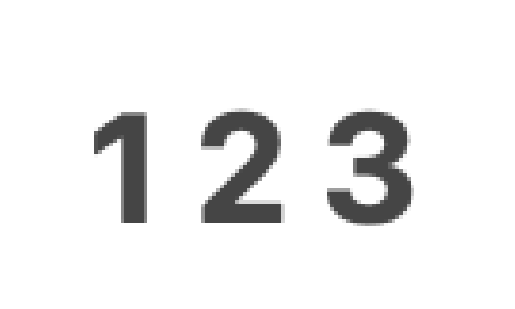

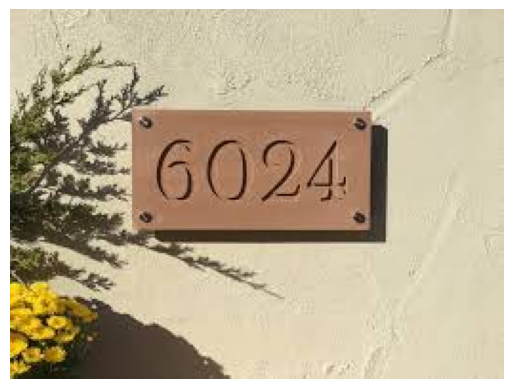

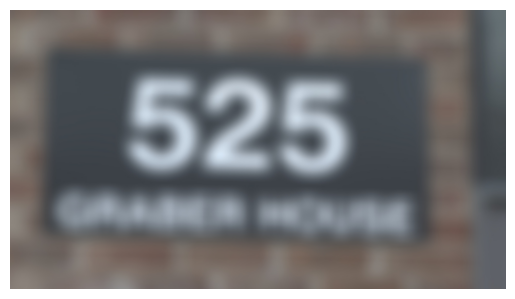

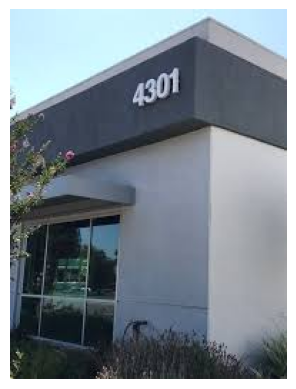

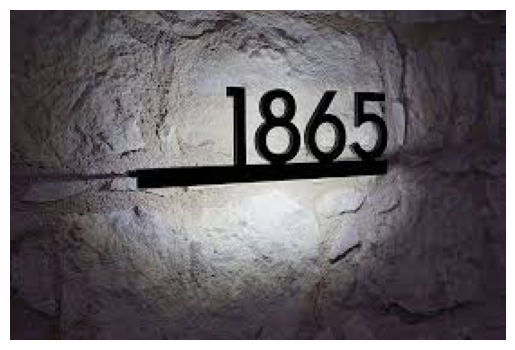

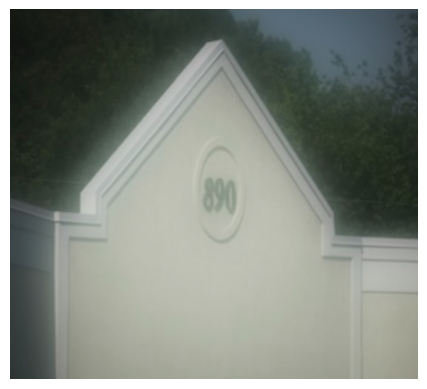

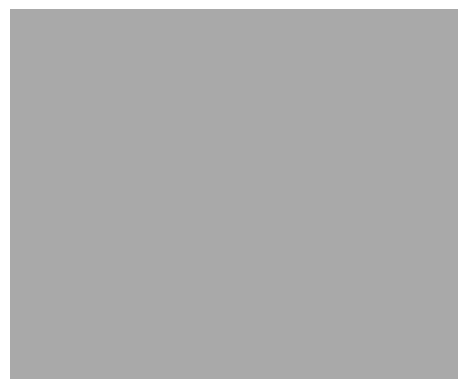

In [9]:
def preprocess_img(img):
    return img

def new_test_pipeline(image_folder):

    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        curr_img = cv2.imread(img_path)
        curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)

        # now we find ROIS... 
        # for each ROI, we apply the model to it...
        # predictions, labels = apply_model_to_data(model_path, individual_image_path, model_name, label=123)
        # print(predictions, labels)


        plt.imshow(curr_img)
        plt.axis('off')
        plt.show()


# new_test_pipeline('test_images')
# special_test = cv2.imread(CURR_INPUT_DIR + 'special-test.jpg')
# new_test_pipeline(special_test)

In [5]:
base_dataset_path = os.path.join('SVHN-dataset', 'cropped-digits')
train_data_path = os.path.join(os.path.join('SVHN-dataset', 'cropped-digits'), 'train.mat')
test_data_path = os.path.join(base_dataset_path, 'test.mat')
individual_image_path = os.path.join('test_images', 'special-test-3.jpg')

model_path = 'current-models/vgg16/best_digit_classifier.pth'
# model_path = 'current-models/vgg16/cross-entropy-0.01-128-ORIGINAL.pth'
model_name = 'vgg16'
batch_size = 64

predictions, labels = apply_model_to_data(model_path, individual_image_path, model_name, label=8)
print(predictions, labels)

RuntimeError: Error(s) in loading state_dict for VGG:
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([4096, 25088]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([4096, 4096]).
	size mismatch for classifier.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([11, 256]) from checkpoint, the shape in current model is torch.Size([11, 4096]).

In [25]:
# k_size = 9                                                                # Gaussian Blurring
# sigma = 10
# curr_img = cv2.GaussianBlur(curr_img, (k_size, k_size), sigma)

# k_size = 3                                                                  # CLAHE-ing
# cliplim = 9.0
# clahe = cv2.createCLAHE(clipLimit=cliplim, tileGridSize=(k_size, k_size))
# curr_img = clahe.apply(curr_img) 

# _, threshold1 = cv2.threshold(curr_img, 0, 80, cv2.THRESH_BINARY)           # Thresholding / Bitwising
# _, threshold2 = cv2.threshold(curr_img, 127, 100, cv2.THRESH_BINARY)
# _, threshold3 = cv2.threshold(curr_img, 255, 200, cv2.THRESH_BINARY)
# curr_img = cv2.bitwise_or( cv2.bitwise_or(threshold1, threshold2), threshold3)

# kernel = np.ones((5, 5), np.uint8)  # Erosion kernel
# curr_img = cv2.erode(curr_img, kernel, iterations=5)
# curr_img = cv2.dilate(curr_img, kernel, iterations=1)





# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # curr_img = cv2.GaussianBlur(curr_img, (5, 5), 0)

    # clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(15, 15))
    # curr_img = clahe.apply(curr_img)


    # kernel = np.ones((3, 3), np.uint8)
    # eroded_img = cv2.erode(img, kernel, iterations=1)

    # curr_img[curr_img < 100] -= 30

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@